In [2]:
%load_ext autoreload
%autoreload 2

In [96]:
import torch
from torch.distributions import Normal

import numpy as np
from tv_snr.snr_schedules import *
from tv_snr.sdes import *
from tv_snr.scale_schedule import *
from tv_snr.sampler import *
from tv_snr.adaptive_scale_sampler import *
from tv_snr.snr import *
from tv_snr.snr_schedules import *
from tv_snr.time_schedules import KVeSchedule, LinearTimeSchedule
from tv_snr.constants import image_key
import matplotlib.pyplot as plt
from tv_snr.adaptive_scale_param_score import *
from tv_snr.noise_schedules import *

def test_case(testcase = "OTFM", T=16):
    sigma_max = 1.0
    time_sched = KVeSchedule(sigma_max=1.0, sigma_min=0.0, discretize=True, T=T)
    if testcase == "OTFM":
        snr_sch = InverseSigmoid(slope=2, shift=0., t_min=0.001, t_max=0.999)
        scale_sch = FMScale(snr_sch)
        sde = Scale_SNR_SDE(
            snr_sch=snr_sch,
            scale_sch=scale_sch,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "VP-OTFM":
        snr_sch = InverseSigmoid(slope=2, shift=0., t_min=0.001, t_max=0.999)
        scale_sch = ConstantScale(snr_sch)
        sde = Scale_SNR_SDE(
            snr_sch=snr_sch,
            scale_sch=scale_sch,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "EDM":
        snr_sch = LinearToSNRSchedule(sigma_min=1e-5, sigma_max=80.0)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=0.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
        sigma_max = 80.0
    elif testcase == "EDM-UT":
        snr_sch = KveToSNRSchedule(t_min=0.0, t_max=1.0, sigma_max=80.0)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=0.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
        time_sched = None
        sigma_max = 80.0
    elif testcase == "VP-EDM":
        snr_sch = LinearToSNRSchedule(sigma_min=0.002, sigma_max=80.0)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=1.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "VP-EDM-UT":
        snr_sch = KveToSNRSchedule(t_min=0.0, t_max=1.0, sigma_max=80.0)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=1.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "VP-ISSNR[$\eta$=1 $\kappa$=2]":
        snr_sch = InverseSigmoid(slope=2, shift=4., t_min=0.001, t_max=0.999)
        scale_sch = ConstantScale(snr_sch)
        sde = Scale_SNR_SDE(
            snr_sch=snr_sch,
            scale_sch=scale_sch,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "VP-ISSNR[$\eta$=1.5 $\kappa$=1]":
        snr_sch = InverseSigmoid(slope=3, shift=2., t_min=0.001, t_max=0.999)
        scale_sch = ConstantScale(snr_sch)
        sde = Scale_SNR_SDE(
            snr_sch=snr_sch,
            scale_sch=scale_sch,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "SMLD":
        snr_sch = VeToSNRSchedule(t_min=0, t_max=1.0, sigma_max=80.0)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=0.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
        time_sched = None
        sigma_max = 80.0
    elif testcase == "VP-SMLD":
        snr_sch = VeToSNRSchedule(t_min=0, t_max=1.0, sigma_max=80.0)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=1.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "DDPM cos-v2.5":
        noise_sch = CosineSchedule(v=2.5, s=1e-5, T=T, discretize=True)
        snr_sch = NoiseToSNRSchedule(noise_sch, t_min=0.001, t_max=0.999)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=1.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "DDPM cos-v1.0":
        noise_sch = CosineSchedule(v=1.0, s=1e-5, T=T, discretize=True)
        snr_sch = NoiseToSNRSchedule(noise_sch, t_min=0.001, t_max=0.999)
        sde = SNR_SDE(
            snr_sch=snr_sch,
            tau=1.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    elif testcase == "DDPM linear":
        linear = LinearSchedule(beta_start=0.1, beta_end=20.0, discretize=True, T=T)
        snr_linear = NoiseToSNRSchedule(linear,t_min=0.001,t_max=0.999)
        sde = SNR_SDE(
            snr_sch=snr_linear,
            tau=1.0,
            invariant=False,
            disc_type="forward",
            log_deriv=True
        )
    else:
        raise ValueError(f"Unknown testcase {testcase}")

    return sde, sde.reverse(stochastic=False), sigma_max, time_sched

64it [00:00, 450.80it/s]
64it [00:00, 482.56it/s]
64it [00:00, 417.79it/s]
64it [00:00, 443.02it/s]
64it [00:00, 550.73it/s]
64it [00:00, 462.75it/s]


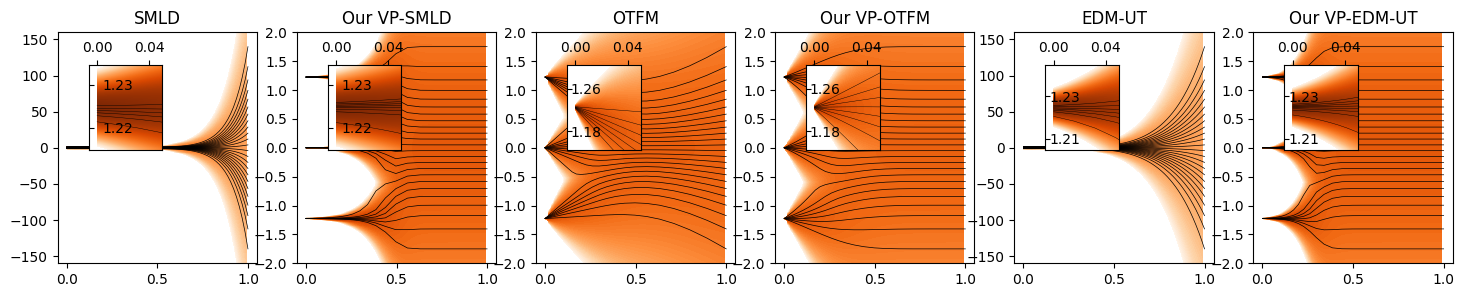

64it [00:00, 401.95it/s]
64it [00:00, 396.19it/s]
64it [00:00, 408.07it/s]
64it [00:00, 479.23it/s]
64it [00:00, 462.58it/s]
64it [00:00, 459.32it/s]


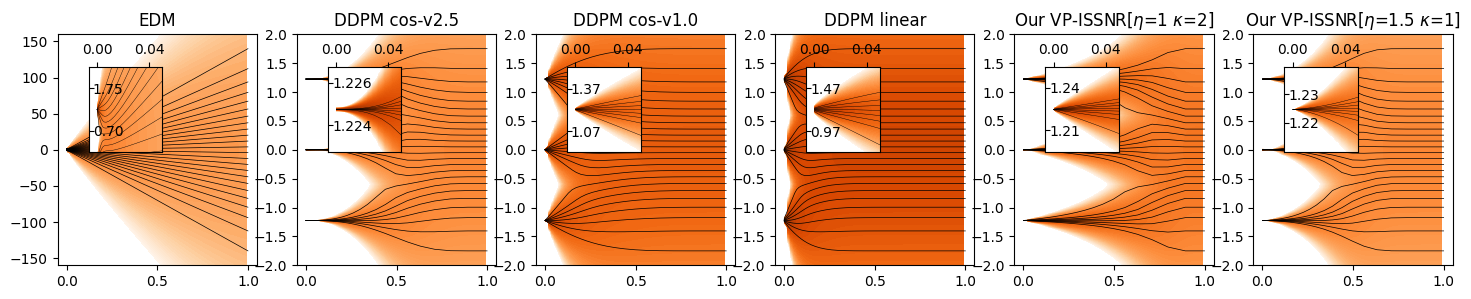

In [133]:
from itertools import product
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from torch.distributions import MixtureSameFamily, Categorical

T = 64
vmin = -12
contours = True

#ccs = [["edm", "vp-issnr[eta=1,k=2]", "vp-issnr[eta=1.5,k=1]", "cos-v2.5", "cos-v1.0"], ["smld", "vp-smld", "otfm", "vp-otfm", "edm-ut", "vp-edm-ut"]]
ccs = [["SMLD", "VP-SMLD", "OTFM", "VP-OTFM", "EDM-UT", "VP-EDM-UT"], ["EDM", "DDPM cos-v2.5", "DDPM cos-v1.0", "DDPM linear", "VP-ISSNR[$\eta$=1 $\kappa$=2]", "VP-ISSNR[$\eta$=1.5 $\kappa$=1]"]]
n_data_points = [3]

for iiii, (ccc, ndp) in enumerate(product(ccs, n_data_points)):
    # individual plots follow

    f, axs = plt.subplots(1, len(ccc), figsize=(3 * len(ccc), 3), squeeze=False)
    axs = axs.flatten()

    for testc, ax in zip(ccc, axs):
        sde, rsde, sigma_max, time_sched = test_case(testc, T)
        nnn = ndp * 3 if ndp > 5 else 24  

        prior = Normal(torch.tensor(0).cuda(), torch.ones(1,).cuda())
        samples = prior.icdf(torch.linspace(0.0, 1.0, nnn + 2)[1:-1].cuda())
        samples = samples.reshape(nnn, 1, 1, 1)

        class AnalyticScoreMultiplePoints(torch.nn.Module):
            def __init__(self, n_points):
                self.n_points = n_points
                self.points_x0 = torch.linspace(-1, 1, self.n_points).float().reshape(-1, 1)

                # standardize the points
                std = torch.sqrt(torch.square(self.points_x0).sum()/self.points_x0.shape[0])
                self.points_x0 = self.points_x0 / std

                super().__init__()
            
            def forward(self, x, t):
                x_shape = x.shape
                x = x.reshape(-1)
                t = t.reshape(-1)

                x = x.clone().detach().requires_grad_(True)
                mog = self.log_prob(x, t)
                score = torch.autograd.grad(mog.sum(), x, create_graph=False)[0]
                score = score.reshape(x_shape)
                return score

            def log_prob(self, x, t):
                t = t.reshape(1, -1)

                means, stds = sde.perturbation_kernel(self.points_x0.to(x.device), t)
                logprobs = Normal(means, stds).log_prob(x)
                logprobs = torch.where(logprobs < -100, torch.tensor(-100, device=x.device).float(), logprobs)

                return torch.log(torch.exp(logprobs).mean(dim=0))

        net = AnalyticScoreMultiplePoints(ndp)

        sampler = SNREulerAdaptiveScaleParamScore(
            T=T,
            time_schedule=time_sched,
            reverse_process = rsde,
            denoiser = net,
            out_var_scaler=1.0,
            scale_input=False,
            snr_key="gamma",
            std_key = "sigma",
            noise_pred_key = "eps_pred",
            max_stoch_std=float('inf'),
            min_stoch_std=0.0,
            clip_stoch_std=False,
            selected_stoch=False,
            save_progress=True,
            conditional=False
        ) 

        ymaxx = 2.0 * sigma_max

        # if testc == "EDM":
        #     tt = np.logspace(-5.5, 0, 45)
        #     xx = np.linspace(-1.0, 1.0, 55) * ymaxx

        #     maxp, minp = net.points_x0.max().item(), net.points_x0.min().item()
        #     xx = np.concatenate([xx, np.linspace(minp * 2.3, maxp * 2.3, 15)])
        # elif sigma_max > 1.0:
        tt = np.linspace(0.0001, 0.99, 55)
        xx = np.linspace(-1.0, 1.0, 55) * ymaxx
        # else:
        #     tt = np.logspace(-5.5, 0, 45)
        #     xx = np.linspace(-1.0, 1.0, 55) * ymaxx

        xx = np.concatenate([xx, net.points_x0.cpu().numpy().squeeze() * 0.996])
        xx = np.concatenate([xx, net.points_x0.cpu().numpy().squeeze() * 1.004])
        xx = np.sort(np.concatenate([xx, net.points_x0.cpu().numpy().squeeze()]))
        TT, XX = np.meshgrid(tt, xx)

        Z = net.log_prob(torch.from_numpy(XX.reshape(-1)).cuda(), torch.from_numpy(TT.reshape(-1)).cuda())
        Z = Z.reshape((TT.shape[0], TT.shape[1])).cpu().numpy()

        oranges = plt.cm.Oranges(np.linspace(0, 1, 256))
        oranges[0] = [1, 1, 1, 1]
        custom_oranges = mcolors.LinearSegmentedColormap.from_list("CustomOranges", oranges)

        if contours:
            ax.contourf(TT, XX, Z, levels=500, vmin=vmin, cmap=custom_oranges)
        levels = np.linspace(vmin, np.max(Z), 10)
        #ax.contour(TT, XX, Z, levels=levels, colors='#FFCCCC', linewidths=0.5)

        result = sampler.denoise({image_key: samples.cuda() * sigma_max})
        traj = result[2]["image"]

        toplotx = torch.linspace(1, 0, traj[0].shape[-1])
        if time_sched is not None:
            toplotx = time_sched(toplotx).numpy()

        for i in range(traj.shape[0]):
            toplot = traj[i].squeeze().detach().numpy()
            #toplotx = torch.linspace(1, 0, toplot.shape[0])
            ax.plot(toplotx, toplot, c="black", linewidth=0.5)

        #if sigma_max > 1.0:
        # plot again
        inset_ax = inset_axes(ax, width="37%", height="37%", loc="upper left", bbox_to_anchor=(0.12, -0.11, 1.0, 1.0), bbox_transform=ax.transAxes)

        inset_ax.yaxis.tick_left()
        inset_ax.xaxis.tick_top()

        topx0 = net.points_x0[-1].item()
        # if testc == "EDM" or testc == "SMLD" or testc == "EDM-UT":
        #     inset_ax.set_ylim(-3, 3)
        #     inset_ax.set_yticks([-2, 0, 2])
        #     ymin = -3
        #     ymax = 3
        # el
        # if testc == "VP-ISSNR[$\eta$=1 $\kappa$=2]" or testc == "VP-ISSNR[$\eta$=1.5 $\kappa$=1]" or testc == "VP-SMLD" or testc == "VP-EDM-UT":
        #     delta = 0.01
        #     inset_ax.set_ylim(topx0 - delta, topx0 + delta)
        #     inset_ax.set_yticks([np.round(topx0 - delta * 0.5, decimals=2), np.round(topx0 + delta * 0.5, decimals=2)])
        #     ymin = topx0 - delta
        #     ymax = topx0 + delta
        # else:
        deccc = 2

        if testc == "SMLD":
            delta = 0.01 # 0.03
            deccc = 3
        elif testc == "VP-SMLD":
            delta = 0.01 # 0.03
            deccc = 3
        elif testc == "OTFM":
            delta = 0.08
        elif testc == "VP-OTFM":
            delta = 0.08
        elif testc == "EDM-UT":
            delta = 0.02
        elif testc == "VP-EDM-UT":
            delta = 0.02
        elif testc == "EDM":
            delta = 1.05
        elif testc == "DDPM cos-v2.5":
            delta = 0.002
            deccc = 3
        elif testc == "DDPM cos-v1.0":
            delta = 0.3
        elif testc == "DDPM linear":
            delta = 0.5
        elif testc == "VP-ISSNR[$\eta$=1 $\kappa$=2]":
            delta = 0.03
        elif testc == "VP-ISSNR[$\eta$=1.5 $\kappa$=1]":
            delta = 0.015
        else:
            raise ValueError(f"Unknown testcase {testc}")

        # if testc == "EDM":
        #     delta = 1.05
        # elif testc == "DDPM cos-v1.0" or testc == "DDPM linear":
        #     delta = 0.5
        # elif "OTFM" in testc:
        #     delta = 0.3
        # elif testc == "DDPM cos-v2.5":
        #     delta = 0.003
        # else: #  or testc.startswith("VP-ISSNR") or testc.index("SMLD") > -1
        #     delta = 0.03

        inset_ax.set_ylim(topx0 - delta, topx0 + delta)
        paddd = -32 if (deccc == 3) else -25
        inset_ax.set_yticks([np.round(topx0 - delta * 0.5, decimals=deccc), np.round(topx0 + delta * 0.5, decimals=deccc)])
        ymin = topx0 - delta
        ymax = topx0 + delta

        inset_ax.yaxis.set_tick_params(direction='in', pad=paddd) 
        inset_ax.set_xticks([0.0, 0.04])
        inset_ax.set_xlim(-0.0065, 0.05)

        tt = np.logspace(-4, np.log10(0.05), 45)
        xx = np.linspace(ymin, ymax, 55)
        TT, XX = np.meshgrid(tt, xx)

        Z = net.log_prob(torch.from_numpy(XX.reshape(-1)).cuda(), torch.from_numpy(TT.reshape(-1)).cuda())
        Z = Z.reshape((TT.shape[0], TT.shape[1])).cpu().numpy()

        if contours:
            inset_ax.contourf(TT, XX, Z, levels=1000, vmin=vmin / 2, cmap=custom_oranges)

        for i in range(traj.shape[0]):
            toplot = traj[i].squeeze().detach().numpy()
            #toplotx = torch.linspace(1, 0, toplot.shape[0])
            inset_ax.plot(toplotx, toplot, c="black", linewidth=0.3)
        # end inset

        ax.set_ylim(-ymaxx, ymaxx)
        title = f"{testc}"
        if testc[0] == "V":
            title = "Our " + title
        ax.set_title(title)  # - {ndp} deltas
    
    plt.savefig(f"figures/toy_example{iiii}_{ndp}_deltas.pdf", bbox_inches='tight', pad_inches=0)
    plt.savefig(f"figures/toy_example{iiii}_{ndp}_deltas.png", bbox_inches='tight', pad_inches=0)
    plt.show()